In [3]:
import os.path as op
import os
import numpy as np
import pandas as pd

bids_folder = '/Users/mrenke/data/ds-dnumrisk'



In [9]:
from utils_02 import build_model
from utils import get_data
import arviz as az

df = get_data()

format = 'symbolic'
model_label = '4'

df = df.xs(format,0, level='format')
model = build_model(model_label, df)

idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels_risk/model-{model_label}_format-{format}_trace.netcdf'))




number of subjects found: 64


In [6]:
model.prior_estimate

'klw'

            rnp          
        hdi_low  hdi_high
subject                  
1           0.0  0.492722
2           0.0  0.505051
3           0.0  0.495153
4           0.0  0.503256
5           0.0  0.512372
...         ...       ...
60          0.0  0.547870
61          0.0  0.487228
62          0.0  0.548397
63          0.0  0.494798
64          0.0  0.540765

[64 rows x 2 columns]


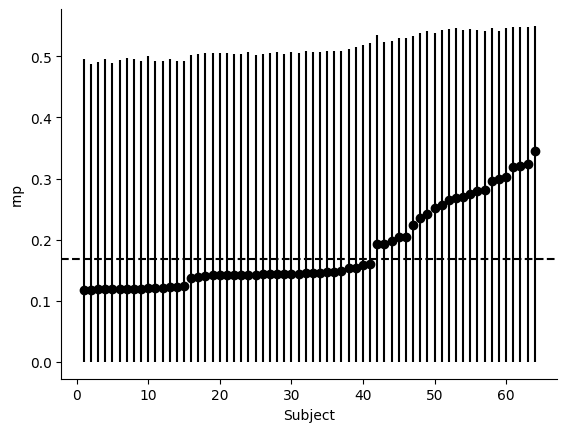

In [13]:
from bauer.utils.plotting import plot_subjectwise_parameters
from utils_02 import get_rnp

idata.posterior['rnp'] = get_rnp(idata.posterior['evidence_sd'], idata.posterior['prior_sd'])
idata.posterior['rnp_mu'] = get_rnp(idata.posterior['evidence_sd_mu'], idata.posterior['prior_sd_mu'])

plot_subjectwise_parameters(idata, parameter='rnp')

In [14]:
par = 'rnp'
traces = idata.posterior[par+'_mu'].to_dataframe()

In [16]:
traces

rnp_mu
chain draw prior_sd_regressors evidence_sd_regressors          
0     0    Intercept           Intercept               0.035903
                               group                   0.064763
           group               Intercept               0.000057
                               group                   0.000413
      1    Intercept           Intercept               0.073517
...                                                         ...
3     998  group               group                   0.000123
      999  Intercept           Intercept               0.343010
                               group                   0.202086
           group               Intercept               0.229516
                               group                   0.086203

[16000 rows x 1 columns]

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from bauer.utils.bayes import softplus

target_folder = op.join(bids_folder, f'derivatives/cogmodels_risk/figures/{model_label}_format-{format}')

par = 'rnp'

for regressor, t in traces.groupby('evidence_sd_regressors'):
            t = t.copy()
            print(regressor, t)
            if (par in ['prior_std', 'evidence_sd']) & (regressor == 'Intercept'): #  'risky_prior_std', 'safe_prior_std', 'n1_evidence_sd', 'n2_evidence_sd',
                t = softplus(t)

            plt.figure()
            sns.kdeplot(t, fill=True)
            if regressor != 'Intercept':
                plt.axvline(0.0, c='k', ls='--')
                txt = f'p({par} < 0.0) = {np.round((t.values < 0.0).mean(), 3)}'
                plt.xlabel(txt)

            else:
                if par == 'risky_prior_mu':
                    plt.axvline(np.log(df['n_risky']).mean(), c='k', ls='--')
                elif par == 'risky_prior_std':
                    plt.axvline(np.log(df['n_risky']).std(), c='k', ls='--')
                elif par == 'safe_prior_mu':
                    for n_safe in np.log([7., 10., 14., 20., 28.]):
                        plt.axvline(n_safe, c='k', ls='--')

                    plt.axvline(np.log(df['n_safe']).mean(), c='k', ls='--', lw=2)
                elif par == 'safe_prior_std':
                    plt.axvline(np.log(df['n_safe']).std(), c='k', ls='--')

            plt.savefig(op.join(target_folder, f'group_par-{par}.{regressor}.pdf'))
            plt.close()


Intercept                                                              rnp_mu
chain draw prior_sd_regressors evidence_sd_regressors              
0     0    Intercept           Intercept               3.590307e-02
           group               Intercept               5.685179e-05
      1    Intercept           Intercept               7.351729e-02
           group               Intercept               1.070663e-01
      2    Intercept           Intercept               1.007758e-01
...                                                             ...
3     997  group               Intercept               5.943070e-09
      998  Intercept           Intercept               0.000000e+00
           group               Intercept               1.007689e-03
      999  Intercept           Intercept               3.430095e-01
           group               Intercept               2.295156e-01

[8000 rows x 1 columns]
group                                                              rnp_mu
chain d